In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


First we will be extracting COVID19 Data from Wikipedia

In [2]:
covid_url = "https://en.wikipedia.org/wiki/COVID-19_pandemic_by_country_and_territory"
r=requests.get(covid_url).text
soup=BeautifulSoup(r, "html.parser")

In [3]:
soup.title

<title>COVID-19 pandemic by country and territory - Wikipedia</title>

In [4]:
table = soup.find_all("table")
case_table = table[12]

In [5]:
columns_extract = case_table.find_all("th",{"scope":"col"})
column_names = [title.text.strip() for title in columns_extract]
print(column_names)

['Country', 'Deaths / million', 'Deaths', 'Cases']


In [6]:
covid_df = pd.DataFrame(columns=column_names)

In [7]:
country_extract = case_table.find_all("th",{"scope":"row"}) #country names are assigned as th
country_names = [country.text.strip() for country in country_extract] #stripping data

In [8]:
covid_df = covid_df.drop(columns=['Country'])

In [9]:
column_data = case_table.find_all("tr")
for row in column_data[1:-1]:
    row_data = row.find_all('td')
    individual_row_data = [data.text.strip() for data in row_data]
    individual_row_data_first = individual_row_data[1:]
    length = len(covid_df)
    covid_df.loc[length] = individual_row_data_first
    #Error is from the last datapoint which is blank

In [10]:
covid_df['Country'] = country_names

Cleaning the Data for our Covid DF

In [11]:
covid_df = covid_df[['Country','Deaths / million','Deaths','Cases']]
covid_df = covid_df.rename(columns={"Deaths / million":"Deaths_per_million"})
covid_df = covid_df.loc[1:]
numeric_cols = ['Deaths_per_million', 'Deaths', 'Cases']
for col in numeric_cols:
    covid_df[col] = covid_df[col].str.replace(',', '')
    covid_df[col] = covid_df[col].str.replace("—","0")
    covid_df[col] = pd.to_numeric(covid_df[col])

In [12]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 1 to 238
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             238 non-null    object
 1   Deaths_per_million  238 non-null    int64 
 2   Deaths              238 non-null    int64 
 3   Cases               238 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ KB


Next I want to extract HDI of Countries to know if they are developed or not

In [13]:
hdi_url = "https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index"
r=requests.get(hdi_url).text
soup=BeautifulSoup(r, "html.parser")

In [14]:
soup.title

<title>List of countries by Human Development Index - Wikipedia</title>

In [15]:
table = soup.find_all("table")
hdi_table = table[1]

In [16]:
header_table = hdi_table.find_all("th")
header_table_titles = [title.text.strip() for title in header_table]
hdi_country_name = header_table_titles[7:]
hdi_headers = header_table_titles[0:3]
hdi_df = pd.DataFrame(columns=hdi_headers)

In [17]:
column_data = hdi_table.find_all("tr")
hdi_data = []
rank_data = []
for row in column_data[1:]:
    row_data = row.find_all('td')
    initial_row_data = [data.text.strip() for data in row_data]
    if len(initial_row_data) == 4:
        hdi_data.append(initial_row_data[2])
        rank_data.append(initial_row_data[0])
    elif len(initial_row_data) == 2:
        hdi_data.append(hdi_data[-1])
        rank_data.append(rank_data[-1])
    else:
        continue
hdi_df['Rank'] = rank_data
hdi_df['HDI'] = hdi_data
hdi_df['Nation'] = hdi_country_name
hdi_df = hdi_df.rename(columns={'Nation':'Country'})
numeric_cols = ['Rank','HDI']

for col in numeric_cols:
    hdi_df[col] = pd.to_numeric(hdi_df[col])
    
conditions = [(hdi_df['HDI']<=0.550), #This so to add a classification to categorize HDI
              (hdi_df['HDI']>0.550) & (hdi_df['HDI']<=0.699),
              (hdi_df['HDI']>0.699) & (hdi_df['HDI']<=0.799),
              (hdi_df['HDI']>=0.800)]
values = ['Low','Medium','High','Very High']
hdi_df['Country_Development'] = np.select(conditions,values)

In [18]:
for row in column_data[1:]:
    row_data = row.find_all('td')
    initial_row_data = [data.text.strip() for data in row_data]
    print(initial_row_data)

[]
['1', '', '0.962', '0.19%']
['2', '', '0.961', '0.19%']
['3', '', '0.959', '0.56%']
['4', '(3)', '0.952', '0.44%']
['5', '(3)', '0.951', '0.27%']
['6', '', '0.948', '0.34%']
['7', '(2)', '0.947', '0.36%']
['8', '(6)', '0.945', '0.40%']
['9', '(5)', '0.942', '0.16%']
['10', '(1)', '0.941', '0.24%']
['11', '', '0.940', '0.29%']
['12', '(1)', '0.939', '0.29%']
['13', '(2)', '0.937', '0.25%']
['(3)', '0.15%']
['15', '(2)', '0.936', '0.25%']
['16', '(1)', '0.935', '0.22%']
['17', '(3)', '0.930', '0.18%']
['18', '(3)', '0.929', '0.17%']
['19', '', '0.925', '0.27%']
['(3)', '0.35%']
['21', '(3)', '0.921', '0.10%']
['22', '', '0.919', '0.25%']
['23', '(4)', '0.918', '0.58%']
['(1)', '0.28%']
['25', '(4)', '0.916', '0.14%']
['26', '(9)', '0.911', '0.80%']
['27', '', '0.905', '0.38%']
['28', '(3)', '0.903', '0.27%']
['29', '(3)', '0.896', '0.41%']
['30', '(1)', '0.895', '0.13%']
['31', '(2)', '0.890', '0.30%']
['32', '(6)', '0.889', '0.20%']
['33', '(2)', '0.887', '0.19%']
['34', '(1)', '0.87

Next step is to standardize our data first and make sure country names are almost consistent

We will start first with our covid_df

In [19]:
covid_df = covid_df[~covid_df["Country"].str.contains("European")] # to remove european union
covid_df = covid_df.replace("China[c]","China") 
covid_df = covid_df.set_index("Country")

Next We want to merge our dataframes

In [20]:
hdi_df.shape

(191, 4)

In [21]:
df = hdi_df.merge(covid_df, on='Country')
df = df.drop(columns = 'Rank')
df['Population_in_millions'] = (df['Deaths']/df['Deaths_per_million'])
df['Percentage_of_cases'] = (df['Cases']/(df['Population_in_millions']*1000000))
df['Death_percentage_of_cases'] = (df['Deaths']/df['Cases'])
df.shape #onyl removed 4 datapoints

(187, 9)

Analysis portion: Top 5 countries with the highest amount of cases

In [23]:
df.isnull().sum()

Country                      0
HDI                          0
Country_Development          0
Deaths_per_million           0
Deaths                       0
Cases                        0
Population_in_millions       1
Percentage_of_cases          1
Death_percentage_of_cases    1
dtype: int64

In [24]:
df = df.dropna()

In [25]:
df.isnull().sum()

Country                      0
HDI                          0
Country_Development          0
Deaths_per_million           0
Deaths                       0
Cases                        0
Population_in_millions       0
Percentage_of_cases          0
Death_percentage_of_cases    0
dtype: int64

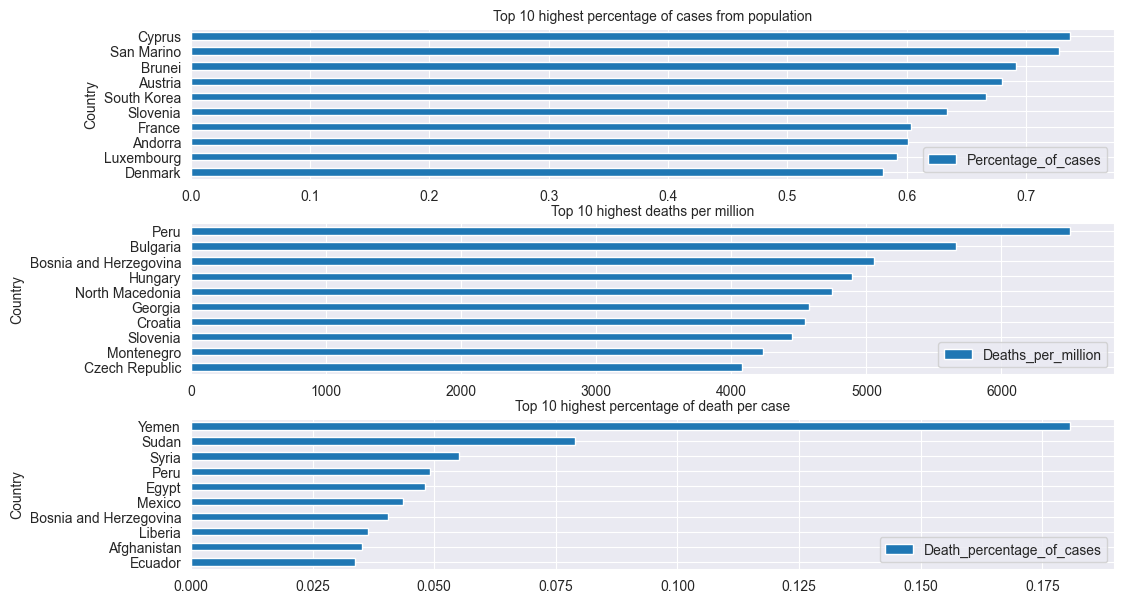

In [26]:
fig, axs = plt.subplots(3,1,figsize=(10,6))
fig.tight_layout()
cases = df.sort_values(['Percentage_of_cases'],ascending=False)
cases.head(10).plot(kind='barh', y='Percentage_of_cases',x='Country',ax=axs[0],title='Top 10 highest percentage of cases from population').legend(loc='lower right')
axs[0].invert_yaxis()

deaths = df.sort_values(['Deaths_per_million'],ascending=False)
deaths.head(10).plot(kind='barh',y='Deaths_per_million',x='Country',ax=axs[1],title='Top 10 highest deaths per million').legend(loc='lower right')
axs[1].invert_yaxis()

percentdeath = df.sort_values(['Death_percentage_of_cases'],ascending=False)
percentdeath.head(10).plot(kind='barh',y='Death_percentage_of_cases',x='Country',ax=axs[2],title='Top 10 highest percentage of death per case').legend(loc='lower right')
axs[2].invert_yaxis()

axs[0].title.set_size(10)
axs[1].title.set_size(10)
axs[2].title.set_size(10)

Death_percentage_of_cases    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

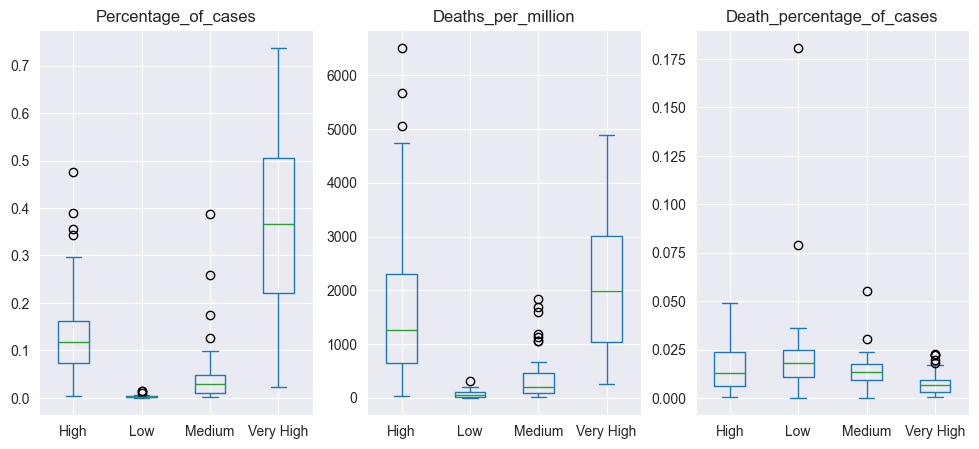

In [27]:
#rows_plot = len(df['Country_Development'].unique())/2
#cols_plot = rows_plot - (len(df['Country_Development']))
fig,axs = plt.subplots(1,3,figsize=(12,5))

cases_hdi = df[['Percentage_of_cases','Country_Development']]
cases_hdi.plot(kind='box',by='Country_Development',ax=axs[0])
    
death_hdi = df[['Deaths_per_million','Country_Development']]
death_hdi.plot(kind='box',by='Country_Development',ax=axs[1])
    
deathpercent_hdi = df[['Death_percentage_of_cases','Country_Development']]
deathpercent_hdi.plot(kind='box',by='Country_Development',ax=axs[2])

let us make sense out of the data

Text(0, 0.5, '')

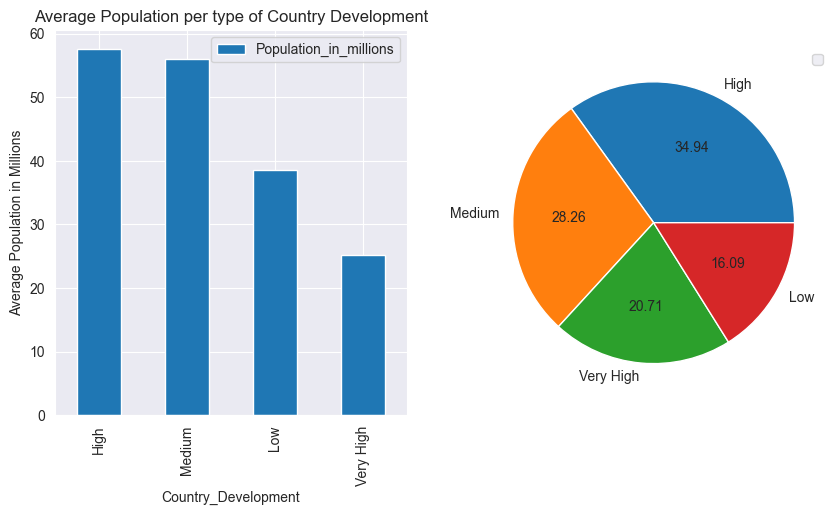

In [29]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
population = df[['Population_in_millions','Country_Development']]
population.groupby(['Country_Development'],as_index=True).mean().sort_values('Population_in_millions',ascending=False).plot(kind='bar',ax=axs[0],ylabel='Average Population in Millions',title = 'Average Population per type of Country Development')
population.groupby(['Country_Development'],as_index=True).sum().sort_values('Population_in_millions',ascending=False).plot(kind='pie',y='Population_in_millions',autopct="%.2f",ax=axs[1])
axs[1].legend("")
axs[1].set_ylabel("")